In [1]:
!pip install torch==2.0.1 pytorch-lightning==2.0.2 pytorch_forecasting==1.0.0 torchaudio==2.0.2 torchdata==0.6.1 torchtext==0.15.2 torchvision==0.15.2 optuna==3.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [2]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TimeSeriesDataSet, TemporalFusionTransformer, DeepAR, NHiTS
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE, MAE, SMAPE, PoissonLoss, QuantileLoss, NormalDistributionLoss, MQF2DistributionLoss
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import tensorflow as tf
from torchmetrics.functional import r2_score

import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Hahaton_Media/train/data_fill_KPI.xlsx')
df_no_header = data.drop('Unnamed: 0', axis=1)

df_no_header.loc[-1] = df_no_header.columns # adding a row
df_no_header.index = df_no_header.index + 1  # shifting index
df_no_header.sort_index(inplace=True)
df_no_header

,год,неделя,Начало нед,"Продажи, рубли","Продажи, упаковки","Продажи, рубли1","раствор 001 % 150 мл N1, руб","раствор 001 % 50 мл N1, руб","раствор 001 % 500 мл N1, руб","раствор 001 % 150 мл N1, упаковки",...,"ТВ Рег, рубли5",Итого11,"ТВ, trp\n(Ж 30-60 ВС)12","ТВ, охват 5+\n(Ж 30-60 ВС)12","ТВ, рубли12","Диджитал, руб12","ТВ спонсорство, рубли12","OOH, рубли12","Радио, рубли13",Итого12
0,год,неделя,Начало нед,"Продажи, рубли","Продажи, упаковки","Продажи, рубли1","раствор 001 % 150 мл N1, руб","раствор 001 % 50 мл N1, руб","раствор 001 % 500 мл N1, руб","раствор 001 % 150 мл N1, упаковки",...,"ТВ Рег, рубли5",Итого11,"ТВ, trp\n(Ж 30-60 ВС)12","ТВ, охват 5+\n(Ж 30-60 ВС)12","ТВ, рубли12","Диджитал, руб12","ТВ спонсорство, рубли12","OOH, рубли12","Радио, рубли13",Итого12
1,2019.0,1,2018-12-31 00:00:00,41535567.339,114621.15,0.0,0.0,0.0,0.0,0.0,...,7155663.632419,11834254.13,207.903106,15.3615,9085528.010323,0.0,0.0,0.0,0.0,9085528.01
2,NaN,2,2019-01-07 00:00:00,51222286.227,141523.2,0.0,0.0,0.0,0.0,0.0,...,8348274.237823,13996532.16,317.467542,25.5255,10599782.67871,0.0,0.0,0.0,0.0,10599782.68
3,NaN,3,2019-01-14 00:00:00,57127348.908,157926.3,0.0,0.0,0.0,0.0,0.0,...,8348274.237823,11466294.66,192.816682,13.9125,10599782.67871,0.0,0.0,0.0,0.0,10599782.68
4,NaN,4,2019-01-21 00:00:00,63040990.9395,173746.65,0.0,0.0,0.0,0.0,0.0,...,8348274.237823,10764632.16,138.371621,8.0535,10599782.67871,0.0,0.0,0.0,0.0,10599782.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,NaN,49,2024-12-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
311,NaN,50,2024-12-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,NaN,51,2024-12-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,NaN,52,2024-12-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
namelist = [v for i, v in df_no_header.iloc[0].reset_index(drop=True).items()]
namelist_wo_dups = [v + str(namelist[:i].count(v) + 1) if namelist.count(v) > 1 else v for i, v in enumerate(namelist)]
pd.DataFrame(namelist_wo_dups)

,0
0,год
1,неделя
2,Начало нед
3,"Продажи, рубли"
4,"Продажи, упаковки"
...,...
142,"Диджитал, руб12"
143,"ТВ спонсорство, рубли12"
144,"OOH, рубли12"
145,"Радио, рубли13"


In [6]:
df2 = df_no_header
#df2.columns = namelist_wo_dups
#df = df2.drop([4]).reset_index(drop=True)
df2.insert(0, 'time_idx', df2.index)
df = df2[1:]
df

<ipython-input-6-ae6b5863923a>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2.insert(0, 'time_idx', df2.index)


,time_idx,год,неделя,Начало нед,"Продажи, рубли","Продажи, упаковки","Продажи, рубли1","раствор 001 % 150 мл N1, руб","раствор 001 % 50 мл N1, руб","раствор 001 % 500 мл N1, руб",...,"ТВ Рег, рубли5",Итого11,"ТВ, trp\n(Ж 30-60 ВС)12","ТВ, охват 5+\n(Ж 30-60 ВС)12","ТВ, рубли12","Диджитал, руб12","ТВ спонсорство, рубли12","OOH, рубли12","Радио, рубли13",Итого12
1,1,2019.0,1,2018-12-31 00:00:00,41535567.339,114621.15,0.0,0.0,0.0,0.0,...,7155663.632419,11834254.13,207.903106,15.3615,9085528.010323,0.0,0.0,0.0,0.0,9085528.01
2,2,NaN,2,2019-01-07 00:00:00,51222286.227,141523.2,0.0,0.0,0.0,0.0,...,8348274.237823,13996532.16,317.467542,25.5255,10599782.67871,0.0,0.0,0.0,0.0,10599782.68
3,3,NaN,3,2019-01-14 00:00:00,57127348.908,157926.3,0.0,0.0,0.0,0.0,...,8348274.237823,11466294.66,192.816682,13.9125,10599782.67871,0.0,0.0,0.0,0.0,10599782.68
4,4,NaN,4,2019-01-21 00:00:00,63040990.9395,173746.65,0.0,0.0,0.0,0.0,...,8348274.237823,10764632.16,138.371621,8.0535,10599782.67871,0.0,0.0,0.0,0.0,10599782.68
5,5,NaN,5,2019-01-28 00:00:00,67336888.8675,185551.8,0.0,0.0,0.0,0.0,...,8477038.252863,10984967.91,286.984113,24.2235,12893092.405548,0.0,0.0,0.0,0.0,12893092.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,310,NaN,49,2024-12-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
311,311,NaN,50,2024-12-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,312,NaN,51,2024-12-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,313,NaN,52,2024-12-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


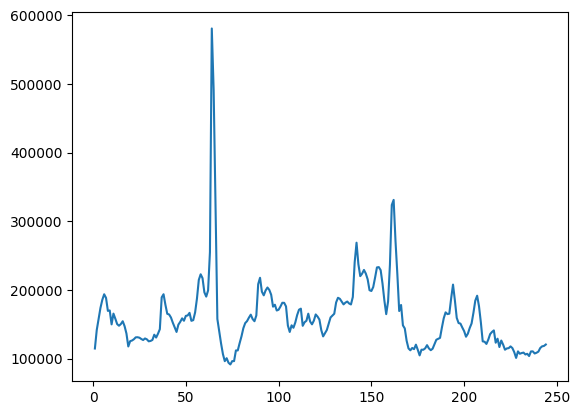

In [7]:
sales = pd.to_numeric(df['Продажи, упаковки']).plot()

In [8]:
df_known = df[:244].drop(columns=['год', 'неделя', 'Начало нед'])
df_known

,time_idx,"Продажи, рубли","Продажи, упаковки","Продажи, рубли1","раствор 001 % 150 мл N1, руб","раствор 001 % 50 мл N1, руб","раствор 001 % 500 мл N1, руб","раствор 001 % 150 мл N1, упаковки","раствор 001 % 50 мл N1, упаковки","раствор 001 % 500 мл N1, упаковки",...,"ТВ Рег, рубли5",Итого11,"ТВ, trp\n(Ж 30-60 ВС)12","ТВ, охват 5+\n(Ж 30-60 ВС)12","ТВ, рубли12","Диджитал, руб12","ТВ спонсорство, рубли12","OOH, рубли12","Радио, рубли13",Итого12
1,1,41535567.339,114621.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7155663.632419,11834254.13,207.903106,15.3615,9085528.010323,0.0,0.0,0.0,0.0,9085528.01
2,2,51222286.227,141523.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8348274.237823,13996532.16,317.467542,25.5255,10599782.67871,0.0,0.0,0.0,0.0,10599782.68
3,3,57127348.908,157926.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8348274.237823,11466294.66,192.816682,13.9125,10599782.67871,0.0,0.0,0.0,0.0,10599782.68
4,4,63040990.9395,173746.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8348274.237823,10764632.16,138.371621,8.0535,10599782.67871,0.0,0.0,0.0,0.0,10599782.68
5,5,67336888.8675,185551.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8477038.252863,10984967.91,286.984113,24.2235,12893092.405548,0.0,0.0,0.0,0.0,12893092.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,240,56931505.0605,110088.3,56931505.0605,31405695.4516,23760363.637,1765445.9719,60729.1,45945.4,3413.8,...,0.0,NaN,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN
241,241,59881512.894,115345.65,59881512.8939,33033037.7728,24991549.4063,1856925.7148,63629.3,48139.5,3576.9,...,0.0,NaN,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN
242,242,61112178.456,117761.7,61112178.456,33711922.1235,25505167.6786,1895088.6539,64962.1,49147.8,3651.8,...,0.0,69394.5,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN
243,243,61594925.028,118356.0,61594925.0279,33978224.4424,25706641.9604,1910058.6251,65289.9,49395.9,3670.2,...,0.0,78529.5,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN


<Axes: >

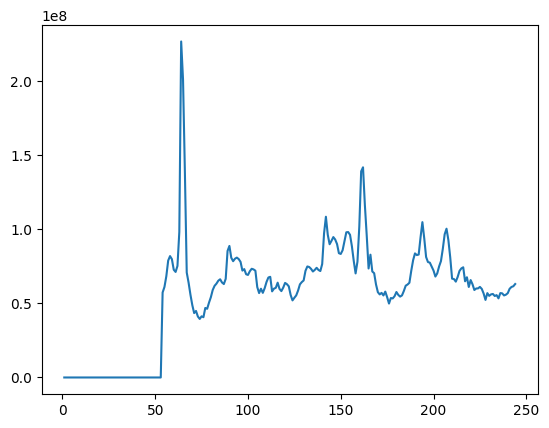

In [9]:
df_known['Продажи, рубли1'].fillna(0).plot()

<Axes: >

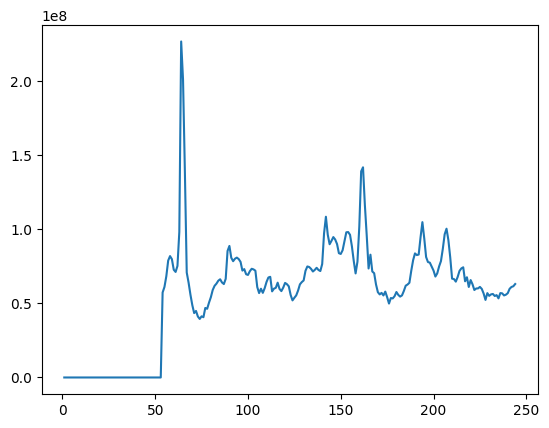

In [10]:
df_known['Продажи, рубли1'].interpolate(method='linear').fillna(0).plot()

In [11]:
df_known = df_known.replace({'0':np.nan, 0:np.nan})
nan_percent_to_drop = 0.8
labels_to_drop = [x for x in df_known.columns if df_known[x].isna().sum()/len(df_known.index) > nan_percent_to_drop]
labels_to_interpolate = [x for x in df_known.columns if 0 < df_known[x].isna().sum()/len(df_known.index) <= nan_percent_to_drop]

In [12]:
df_fucked = df_known.copy()
df_fucked = df_fucked.drop(columns=labels_to_drop)
df_fucked[labels_to_interpolate] = df_fucked[labels_to_interpolate].interpolate(method='linear').fillna(0)

In [13]:
df_fucked.describe()

,time_idx,"Продажи, рубли","Продажи, упаковки","Продажи, рубли1","раствор 001 % 150 мл N1, руб","раствор 001 % 50 мл N1, руб","раствор 001 % 500 мл N1, руб","раствор 001 % 150 мл N1, упаковки","раствор 001 % 50 мл N1, упаковки","раствор 001 % 500 мл N1, упаковки",...,Итого10,"ТВ, trp\n(Ж 30-60 ВС)11","ТВ, охват 5+\n(Ж 30-60 ВС)11","Диджитал, руб11","ТВ Рег, рубли5",Итого11,"ТВ, trp\n(Ж 30-60 ВС)12","ТВ, охват 5+\n(Ж 30-60 ВС)12","Диджитал, руб12",Итого12
count,244.000000,2.440000e+02,244.000000,2.440000e+02,2.440000e+02,2.440000e+02,2.440000e+02,244.000000,244.000000,244.000000,...,2.440000e+02,244.000000,244.000000,2.440000e+02,2.440000e+02,2.440000e+02,244.000000,244.000000,2.440000e+02,2.440000e+02
mean,122.500000,6.797888e+07,159901.242418,5.615704e+07,3.610988e+07,1.856880e+07,1.478359e+06,82148.680328,41934.272131,3326.392213,...,2.676128e+06,177.266405,12.866394,6.689731e+05,6.855917e+06,7.669131e+06,198.554157,13.989679,7.265012e+05,5.392229e+06
std,70.580923,2.137577e+07,53303.366305,3.566772e+07,2.347609e+07,1.148601e+07,9.621979e+05,56221.792718,27127.501036,2238.978768,...,5.131750e+06,88.015816,5.998852,8.280190e+05,4.928232e+06,7.352762e+06,65.026500,5.369407,6.054867e+05,5.660869e+06
min,1.000000,3.953069e+07,91381.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,2.835000e+02,0.179814,0.168000,1.312500e+04,2.627818e+05,1.181216e+04,3.073116,0.010500,0.000000e+00,5.916581e+03
25%,61.750000,5.590158e+07,126147.262500,4.838892e+07,2.944031e+07,1.641525e+07,1.168462e+06,60333.825000,38242.575000,2754.750000,...,7.976194e+04,110.693914,8.016750,1.431776e+05,3.833307e+06,6.329358e+04,177.362587,12.432375,1.470722e+05,5.916581e+03
50%,122.500000,6.298169e+07,152630.100000,6.156343e+07,3.960586e+07,2.177789e+07,1.658725e+06,88393.050000,46610.150000,3636.800000,...,4.581679e+05,193.529794,13.476750,4.263624e+05,4.912060e+06,6.061191e+06,209.441329,14.437500,7.919100e+05,4.378192e+06
75%,183.250000,7.444807e+07,180425.962500,7.444863e+07,4.866984e+07,2.444131e+07,1.952134e+06,116319.600000,55363.750000,4357.850000,...,1.771940e+06,239.197184,17.608500,7.968859e+05,8.528796e+06,1.373022e+07,226.611563,17.180625,8.822637e+05,9.212096e+06
max,244.000000,2.268909e+08,580588.050000,2.268931e+08,1.437059e+08,7.672769e+07,6.459583e+06,367727.100000,196337.500000,16529.300000,...,2.599829e+07,513.223474,31.962000,6.133732e+06,2.978663e+07,3.476581e+07,409.631826,27.541500,3.668254e+06,2.845001e+07


In [14]:
from sklearn.preprocessing import minmax_scale, scale

cols = df_fucked.select_dtypes(np.number).columns
df_fucked[cols] = minmax_scale(df_fucked[cols])

In [15]:
df_fucked.time_idx = df_fucked.time_idx.astype(int)
df_fucked['group'] = 0
df_fucked['time_idx'] = df_fucked.index

In [16]:
df_fucked

,time_idx,"Продажи, рубли","Продажи, упаковки","Продажи, рубли1","раствор 001 % 150 мл N1, руб","раствор 001 % 50 мл N1, руб","раствор 001 % 500 мл N1, руб","раствор 001 % 150 мл N1, упаковки","раствор 001 % 50 мл N1, упаковки","раствор 001 % 500 мл N1, упаковки",...,"ТВ, рубли11","Диджитал, руб11","ТВ Рег, рубли5",Итого11,"ТВ, trp\n(Ж 30-60 ВС)12","ТВ, охват 5+\n(Ж 30-60 ВС)12","ТВ, рубли12","Диджитал, руб12",Итого12,group
1,1,0.010701,0.047505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1645238.93371,0.493452,0.233468,0.340175,0.503814,0.557590,9085528.010323,0.000000,0.319209,0
2,2,0.062402,0.102496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1919445.422661,0.607078,0.273863,0.402392,0.773306,0.926773,10599782.67871,0.000000,0.372445,0
3,3,0.093919,0.136026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1919445.422661,0.193682,0.273863,0.329588,0.466706,0.504958,10599782.67871,0.000000,0.372445,0
4,4,0.125482,0.168365,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1919445.422661,0.079042,0.273863,0.309398,0.332790,0.292143,10599782.67871,0.000000,0.372445,0
5,5,0.148410,0.192496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1911792.160306,0.095254,0.278224,0.315738,0.698327,0.879481,12893092.405548,0.000000,0.453070,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,240,0.092874,0.038239,0.250918,0.218541,0.309671,0.273306,0.165147,0.234012,0.206530,...,0,0.013238,0.120937,0.001574,0.507598,0.524027,0,0.215882,0.000000,0
241,241,0.108619,0.048986,0.263919,0.229866,0.325717,0.287468,0.173034,0.245187,0.216398,...,0,0.011216,0.120937,0.001616,0.507598,0.524027,0,0.215882,0.000000,0
242,242,0.115187,0.053924,0.269343,0.234590,0.332412,0.293376,0.176658,0.250323,0.220929,...,0,0.009193,0.120937,0.001657,0.507598,0.524027,0,0.215882,0.000000,0
243,243,0.117764,0.055139,0.271471,0.236443,0.335037,0.295694,0.177550,0.251587,0.222042,...,0,0.010686,0.120937,0.001920,0.507598,0.524027,0,0.215882,0.000000,0


In [17]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting import NaNLabelEncoder
encoder_length = 28
pred_length = 28
training_cutoff = df_fucked['time_idx'].max() - pred_length


train_dataset = TimeSeriesDataSet(
  df_fucked[lambda x: x.time_idx <= training_cutoff],
  time_idx = 'time_idx',
  target = 'Продажи, упаковки',
  group_ids = ['group'],
  min_encoder_length = encoder_length, # = то, на сколько значений НАЗАД мы смотрим
  max_encoder_length = encoder_length,
  min_prediction_length = pred_length, # = то, на сколько значений ВПЕРЕД мы прогнозируем
  max_prediction_length = pred_length,
  time_varying_unknown_reals = ['Продажи, упаковки']
)

validation_dataset = TimeSeriesDataSet.from_dataset(train_dataset, df_fucked, predict=True, stop_randomization=True, min_prediction_idx=training_cutoff + 1)

batch_size = 16  # set this between 32 to 128
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
train_evaluation_dataloader = train_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=2, batch_sampler="synchronized")
validation_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=2)

In [18]:
!pip install pytorch-forecasting[mqf2]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for cpflows: filename=cpflows-0.1.2-py3-none-any.whl size=54295 sha256=d58b810cbb1af092bbdb8fbe7fa6406ec828bb7731adab01c943156bafd38541
  Stored in directory: /root/.cache/pip/wheels/1b/c3/fd/cdcca84615eb336ec3d17d9d1fd858684240e91b47cf3dab6e
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6488 sha256=9378d206e8a42406249d9dabd554e714ed2a222ea42b132e83bf80b7f701ef94
  Stored in directory: /root/.cache/pip/wheels/64/19/61/d440ccd46a2a014bce61fc5c6c8495dedd32ef04cba8b34b28
Successfully built cpflows subprocess32


In [19]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
lr_logger = LearningRateMonitor(logging_interval='step', log_momentum=True)  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=200,
    accelerator='auto',
    enable_model_summary=True,
    #gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    enable_progress_bar=True, #val_check_interval=10,
    #log_every_n_steps=10,
    logger=logger
)

net = DeepAR.from_dataset(
     train_dataset,
     learning_rate=0.01,
     hidden_size=128,
     #loss=MQF2DistributionLoss(prediction_length=pred_length),
     #optimizer="AdamW",
     rnn_layers=3,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=validation_dataloader
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 11.108
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 11.108


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1.164 >= min_delta = 0.0001. New best score: 9.944
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1.164 >= min_delta = 0.0001. New best score: 9.944


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1.129 >= min_delta = 0.0001. New best score: 8.815
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1.129 >= min_delta = 0.0001. New best score: 8.815


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 2.714 >= min_delta = 0.0001. New best score: 6.101
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 2.714 >= min_delta = 0.0001. New best score: 6.101


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 6.395 >= min_delta = 0.0001. New best score: -0.294
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 6.395 >= min_delta = 0.0001. New best score: -0.294


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.703 >= min_delta = 0.0001. New best score: -0.998
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.703 >= min_delta = 0.0001. New best score: -0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 10 records. Best score: -0.998. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: -0.998. Signaling Trainer to stop.


In [20]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_deepvar = DeepAR.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_0/checkpoints/epoch=15-step=160.ckpt


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [21]:
def evaluate(predictions, answers):
    rmse = RMSE()(predictions, answers).item()
    smape = SMAPE()(predictions, answers).item()
    mae = MAE()(predictions, answers).item()

    print(f"Evaluation Metrics:")
    print(f"RMSE: {rmse:.3f}")
    print(f"SMAPE: {smape:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"===============")

In [22]:
%%time
predictions = best_deepvar.predict(validation_dataloader)
# Запишем ответы из валидации в один тензор, чтобы быстрее считать метрики
val_answers = torch.cat([y[0] for x, y in iter(validation_dataloader)])

print("Our model predictions:")
evaluate(predictions, val_answers)
baseline_predictions = Baseline().predict(validation_dataloader, return_y=False)

print("Baseline model predictions:")
evaluate(baseline_predictions, val_answers)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Our model predictions:
Evaluation Metrics:
RMSE: 0.111
SMAPE: 1.116
MAE: 0.110
Baseline model predictions:
Evaluation Metrics:
RMSE: 0.058
SMAPE: 0.800
MAE: 0.057
CPU times: user 441 ms, sys: 282 ms, total: 723 ms
Wall time: 1.12 s


In [23]:
test_dataset = TimeSeriesDataSet.from_dataset(train_dataset,
                                      df_fucked,
                                      min_prediction_idx=training_cutoff+1,
                                      predict_mode=True)

test_loader = test_dataset.to_dataloader(
    train=False, batch_size=batch_size, num_workers=2, batch_sampler="synchronized"
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


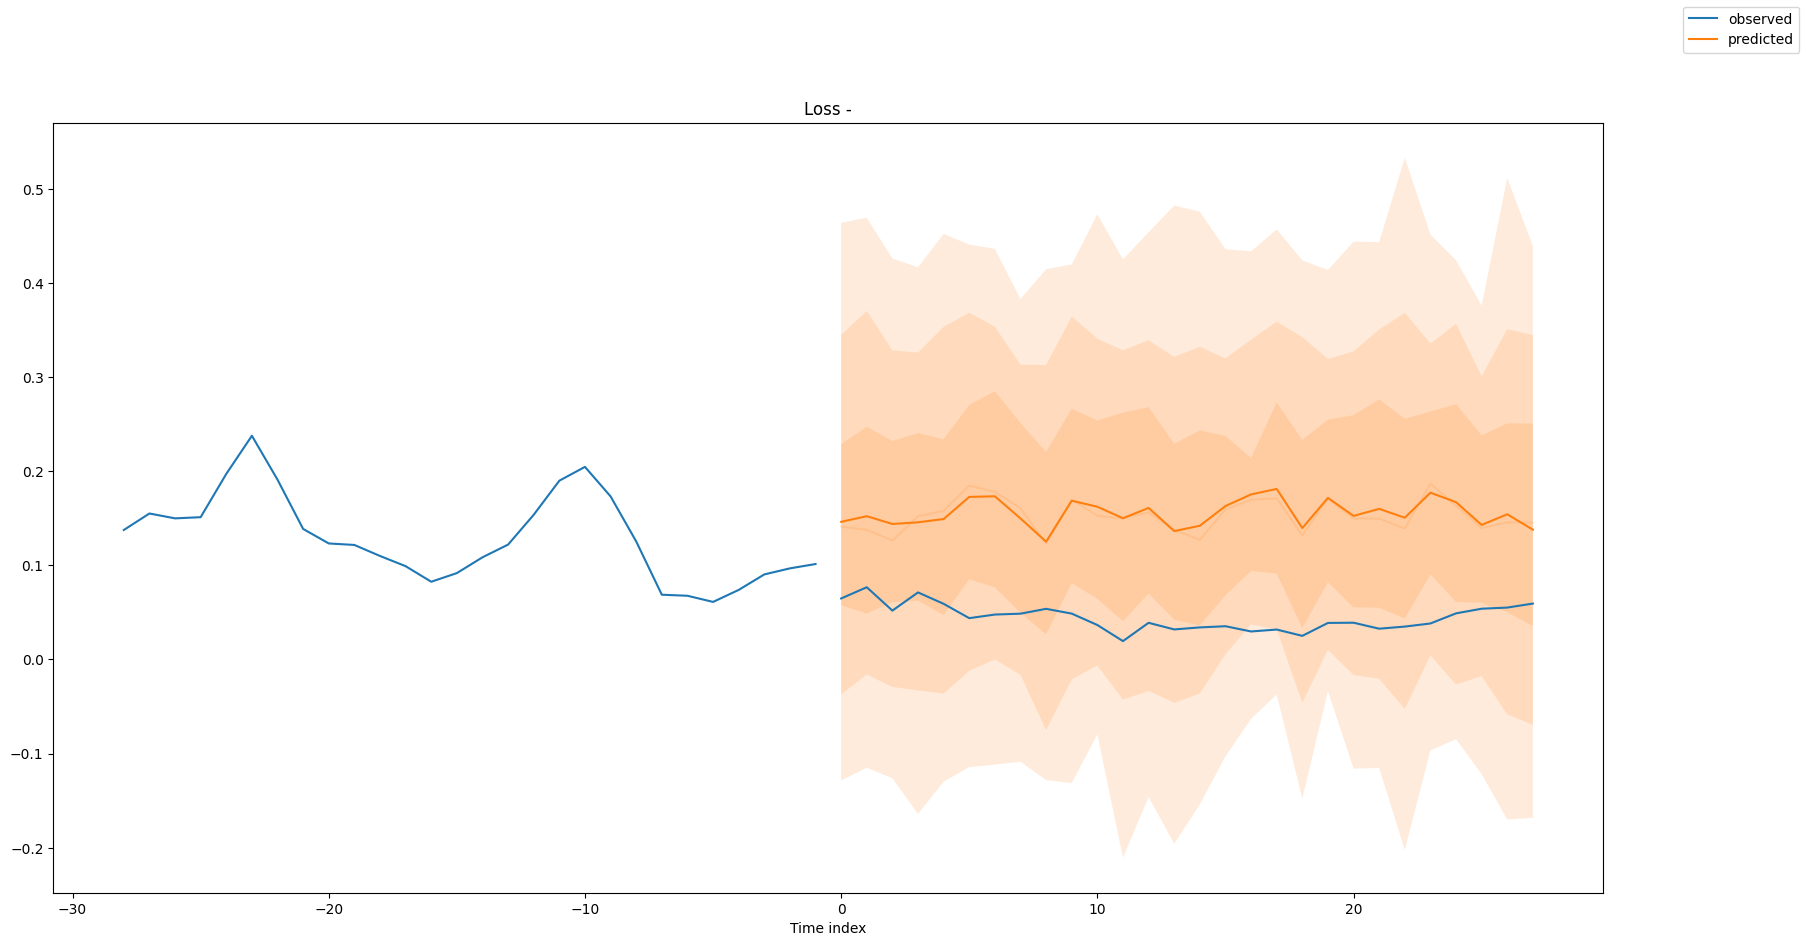

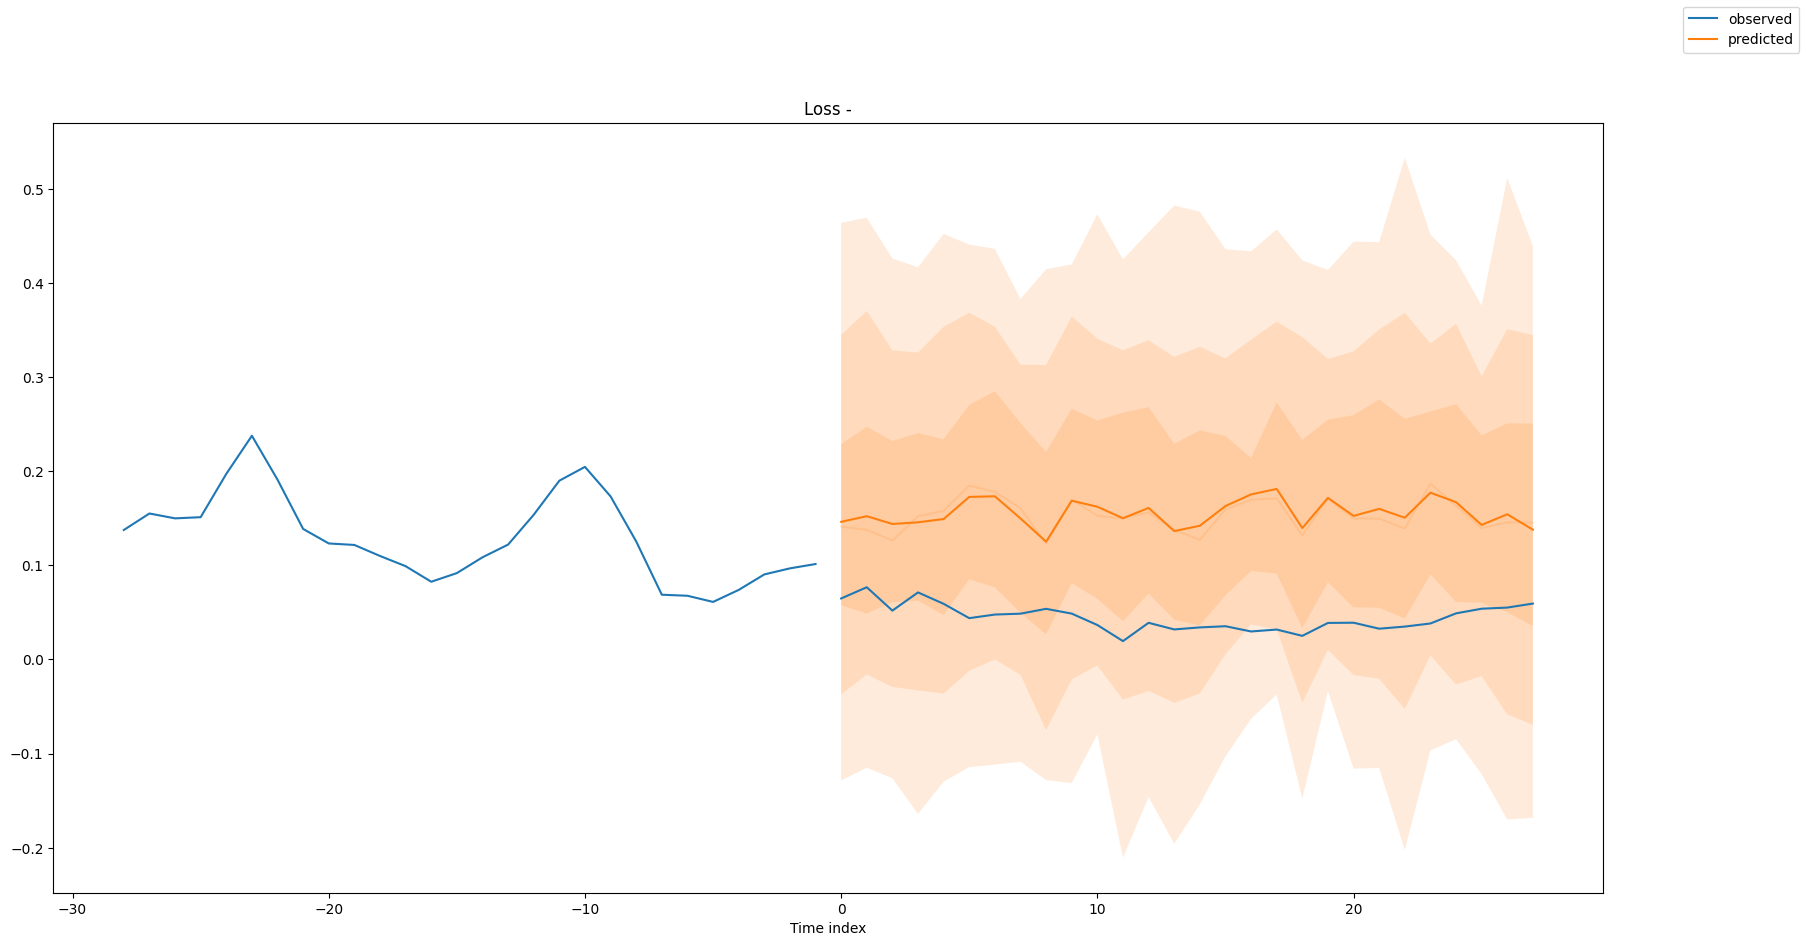

In [24]:
import matplotlib.pyplot as plt

raw_predictions = best_deepvar.predict(test_loader,
                              mode="raw", return_x=True)

test_preds = raw_predictions[0]['prediction']
x = raw_predictions[1]['encoder_target']
fig, ax = plt.subplots(figsize=(20, 10))
best_deepvar.plot_prediction(raw_predictions.x, raw_predictions.output, add_loss_to_title=True, ax=ax)